In [ ]:
!pip install keras==2.2.4

In [ ]:
pip install --user tensorflow-probability --upgrade

In [1]:
import tensorflow as tf
from tensorflow import keras
import cv2
import csv
import math
import numpy as np
import keras.layers as KL
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Lambda, Flatten
from tensorflow.keras.models import Model
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow_probability as tfp
tfd=tfp.distributions
tfpl=tfp.layers
import keras.layers.core as core
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Load Data**

In [ ]:
def read_data(path):

    #open path to read dataset.csv
    csvFile = open(path, "r")
    reader = csv.reader(csvFile)
    #assgin array to load two images and labels
    frame_0 = []
    frame_1 = []
    label = []

    for item in reader:   
    #read frames' path and labels
        frame_0_temp = item[0]
        frame_1_temp = item[1]
        label_temp = item[2]
    #load frame through the frame path
        img0 = cv2.imread(frame_0_temp)
        img1 = cv2.imread(frame_1_temp)
    # use "append" to load images to array
        frame_0.append(img0)
        frame_1.append(img1)
        label.append(label_temp)
    #print('read data part: ',label)
    return frame_0, frame_1, label

def process_data(f0,f1,lab):

  lab=keras.utils.to_categorical(lab, 2)

  f0 = np.asarray(f0)
  f1 = np.asarray(f1)
  lab = np.asarray(lab)

  return f0,f1,lab

In [ ]:
training_path = '/content/drive/MyDrive/Daming Colab/Ranking_siamese network/train_data_set.csv'
validation_path = '/content/drive/MyDrive/Daming Colab/Ranking_siamese network/validation_data_set.csv'

frame_0_train, frame_1_train, label_train = read_data(training_path)
frame_0_val, frame_1_val, label_val = read_data(validation_path)

frame_0_train, frame_1_train, label_train = process_data(frame_0_train, frame_1_train, label_train)
frame_0_val, frame_1_val, label_val = process_data(frame_0_val, frame_1_val, label_val)

print("finish loading DATA !")

finish loading DATA !


# **FireModule for Squeezenet**

In [2]:
def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + 'sq1x1')(x)
    x = Activation('relu', name=s_id + 'relu' + 'sq1x1')(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + 'exp1x1')(x)
    left = Activation('relu', name=s_id + 'relu' + 'exp1x1')(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + 'exp3x3')(x)
    right = Activation('relu', name=s_id + 'relu' + 'exp3x3')(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x

# **Base Model with 1 output only**

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 111, 111, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 111, 111, 64) 0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 55, 55, 64)   0           relu_conv1[0][0]                 
____________________________________________________________________________________________

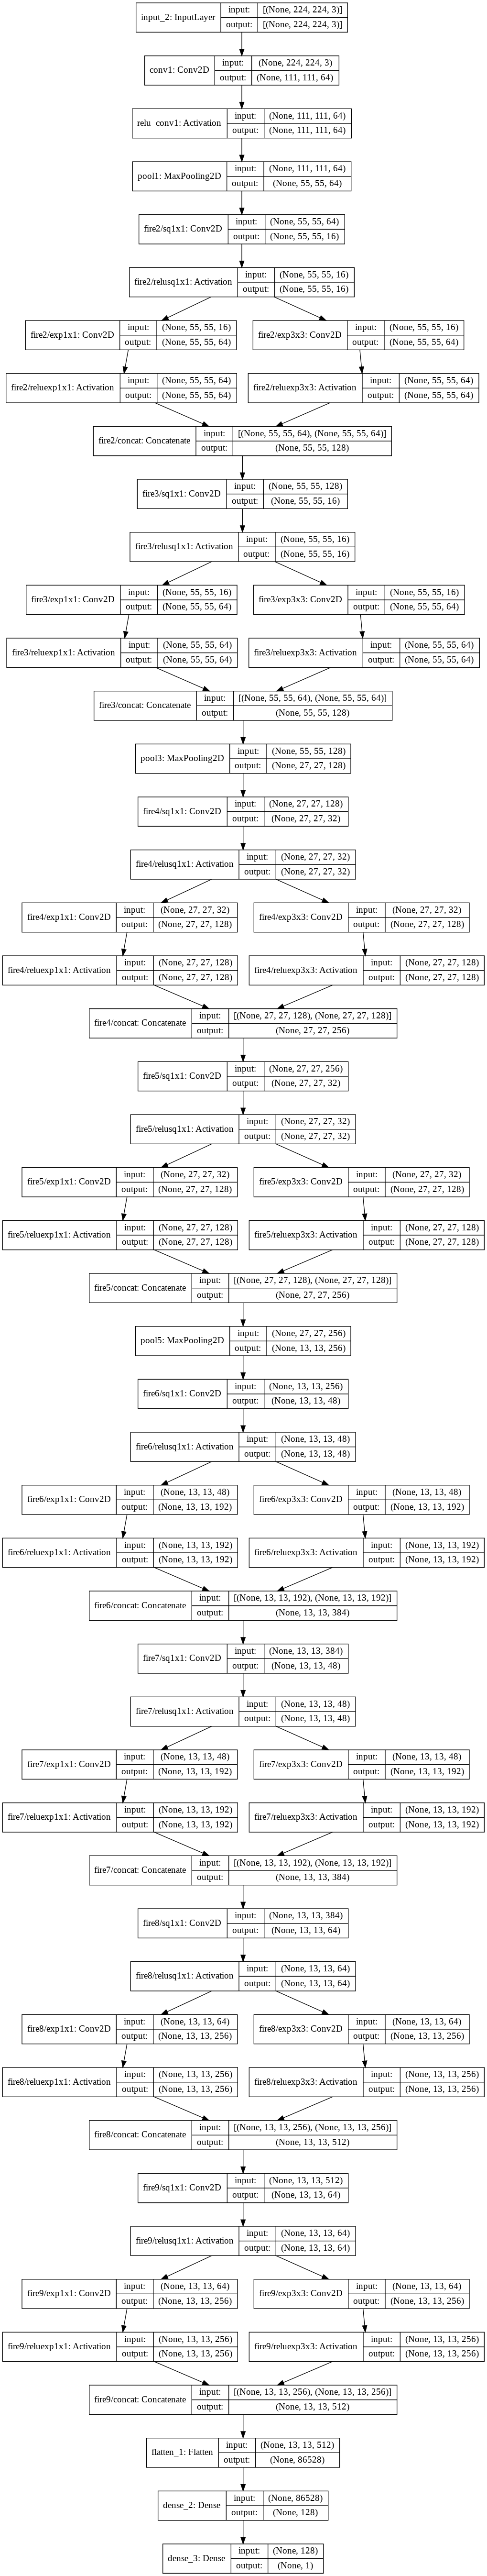

In [4]:
def SqueezeNet():
    
    input_frame = Input(shape=(224, 224, 3))

    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(input_frame)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)

    #x = GlobalAveragePooling2D()(x)
    # use flatten instead of pooling; pooling layer dose not work for single output....

    x = Flatten()(x)
    x = Dense(128, activation="relu")(x)

    # Dense layer with output_size=1
    x = Dense(1)(x)

    model = Model(inputs=input_frame,outputs=x)

    return model

model=SqueezeNet()
model.summary()
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# **Build Model With Distribution**

In [ ]:
class custom_layer(core.Layer):

  def __int__(self,output_dim,**kwargs):
      self.output_dim = output_dim
      super(MyLayer, self).__init__(**kwargs)

  def build(self, input_shape):
      assert isinstance(input_shape, list)
      self.kernal = self.add_weight(name='kernal',
                                    shape=(input_shape[1],self.output_dim),
                                    initializeer='uniform',
                                    trainable=True)
      super(custom_layer, self).build(input_shape)

  def call(self,x):
      assert isinstance(x, list)
      output = K.dot(x, self.kernel)
      output=tfd.Normal(loc=x[0],scale=x[1])
      return output
  
  def compute_output_shape(self, input_shape):
      assert isinstance(input_shape, list)
      return (input_shape[0], self.output_dim)

In [ ]:
# create custom layer
# but error is "can not output tensorspec from tensor normal"
# use lambda layer instead
def distribution(d):
    return tfd.Normal(loc=d[0],scale=d[1])

In [ ]:
# define activation func for stddev
# call while load model
def custom_activation(x):
    return tf.nn.elu(x) + 1

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 111, 111, 64) 1792        input_9[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 111, 111, 64) 0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 55, 55, 64)   0           relu_conv1[0][0]                 
____________________________________________________________________________________________

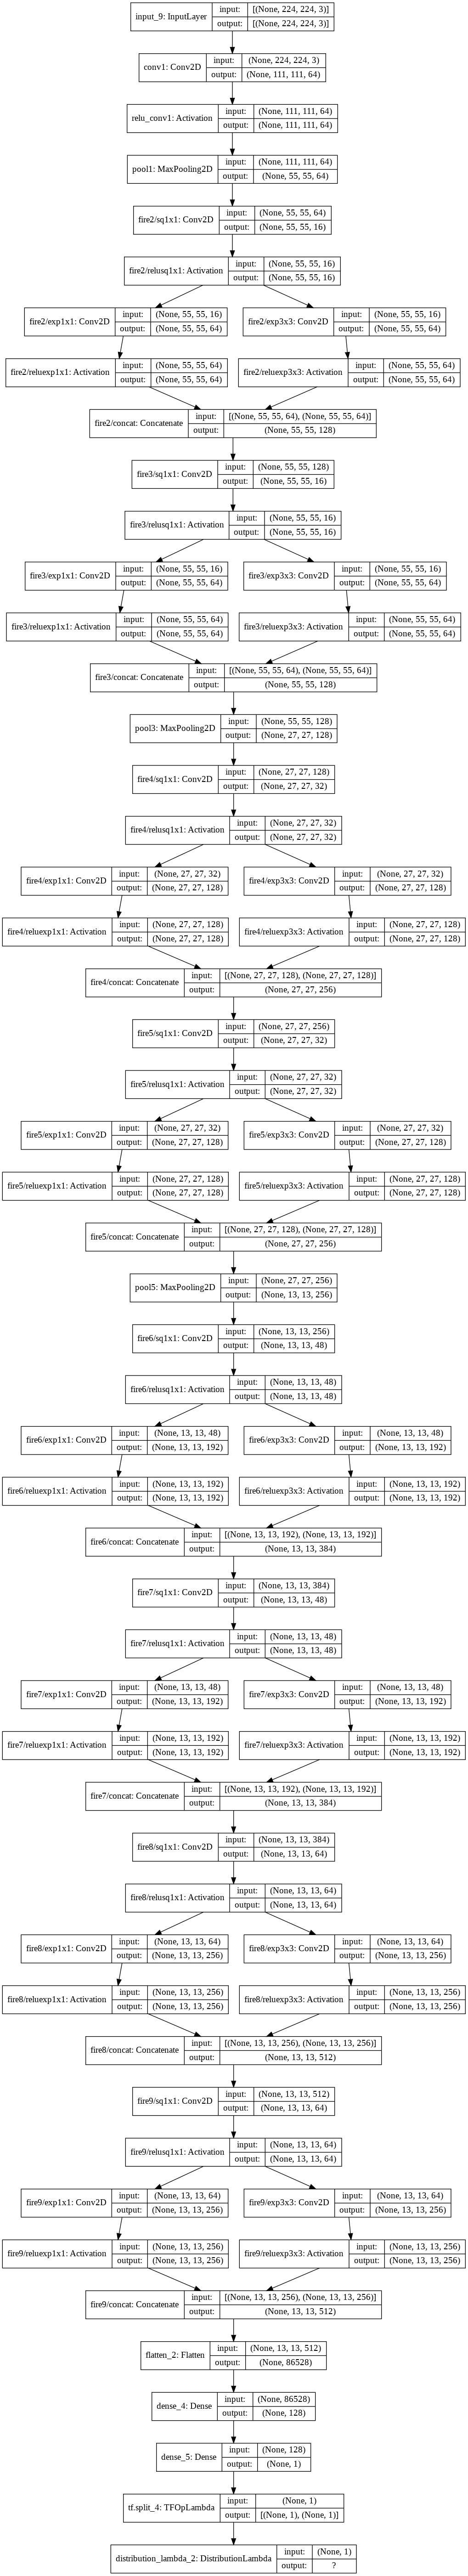

In [ ]:
def SqueezeNet_ND():
    
    input_tensor = Input(shape=(224, 224, 3))
    input_frame = Input(shape=(224, 224, 3))

    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(input_frame)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)

    #x = GlobalMaxPooling2D()(x)
    # regular squeezenet model end here

    x = Flatten()(x)
    x = Dense(128, activation="relu")(x)
    '''
    # MDN 
    mu = Dense(1,activation='linear')(x)                      
    sigma = Dense(units=1, activation=custom_activation)(x)
    '''
    x= Dense(1)(x) # same as the basemodel with 1output
    
    m,s = tf.split(x,2) # split the 'score' to mean and stddev 

    # X ~ Normal(loc=mu, scale=sigma)
    # where loc = mu is the mean, scale = sigma is the std. deviation
    # dist = tfd.Normal(loc=mu,scale=sigma)
    dist = tfpl.DistributionLambda(lambda t : tfd.Normal(
                                    loc=t[0],scale=tf.math.softplus(t[1])),
                                   convert_to_tensor_fn=lambda s: s.sample(20))(m,s)
                                   # output s distribution samples 

    model = Model(input_frame,dist)

    return model
    
    '''
    #both mean and var are trainable
    x = Dense(1+1, activation="relu")(x)
    x=tfpl.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(loc=t[...,:1], scale=tf.math.softplus(t[...,1:]))))(x)
    '''
    '''
    #with IndependentNormal
    event_shape=1
    x=Dense(units=tfpl.IndependentNormal.params_size(event_shape),input_shape=(128,))(x)
    x=tfpl.IndependentNormal(event_shape)(x)
    model = Model(input_frame,x)
    #model = Model(inputs=input_frame,outputs=[mu,sigma])
    return model
    '''
model_ND = SqueezeNet_ND()
model_ND.summary()
plot_model(model_ND, to_file='model_ND.png', show_shapes=True, show_layer_names=True)

**Siamese**

In [ ]:
def siamese():
  
    input_tensor = Input(shape=(224, 224, 3))
    base_model = SqueezeNet()
    #base_model = SqueezeNet_ND()

    input_frame_1 = Input(shape=(224, 224, 3))
    input_frame_2 = Input(shape=(224, 224, 3))
    
    encoded_frame_1 = base_model(input_frame_1)
    encoded_frame_2 = base_model(input_frame_2)
    '''
    encoded_frame_1 = GlobalAveragePooling2D(encoded_frame_1)
    encoded_frame_2 = GlobalAveragePooling2D(encoded_frame_2)
    '''
    '''
    mean_layer = Lambda(lambda tensors: np.mean(tensors))
    m1 = mean_layer(encoded_frame_1)
    m2 = mean_layer(encoded_frame_2)
    '''
    diff = keras.layers.Subtract()([encoded_frame_1,encoded_frame_2])                    
    #diff_mean = diff.mean(axis=1)

    score = Dense(64, activation='relu')(diff)
    score = Dense(2, activation='sigmoid')(score)

    print(score.shape)

    siamese_model = Model([input_frame_1, input_frame_2], score)

    return siamese_model

(None, 2)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 1)            11798337    input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
subtract (Subtract)             (None, 1)            0           model_1[0][0]    

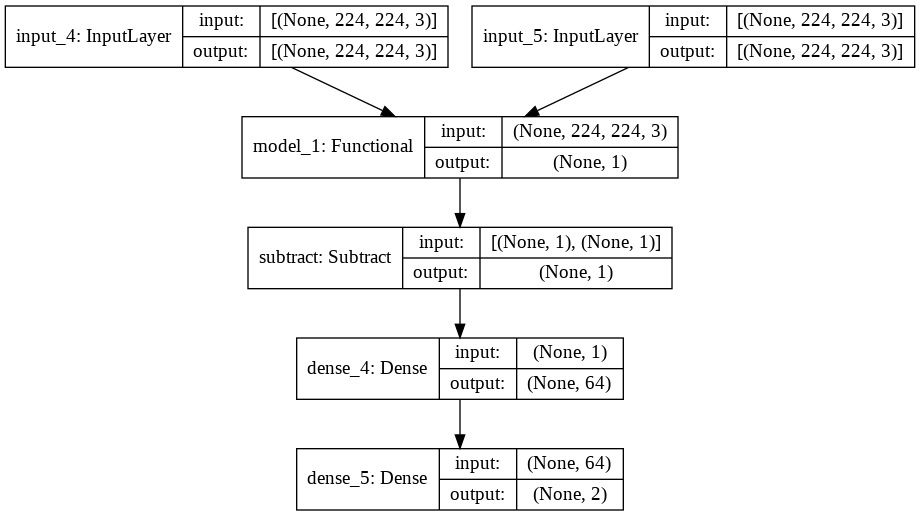

In [ ]:
siamese_model=siamese()
siamese_model.summary()
plot_model(siamese_model, to_file='mode l.png', show_shapes=True, show_layer_names=True)

In [ ]:
siamese_model.compile(keras.optimizers.SGD(learning_rate=1e-3),
                      #notes:change larger lr while training the distribution basemodel
                      loss=keras.losses.binary_crossentropy,
                      metrics=['accuracy'])

history=siamese_model.fit([frame_0_train, frame_1_train], label_train, 
                      epochs=20, batch_size=20, 
                      validation_data=([frame_0_val, frame_1_val], label_val), 
                      shuffle=True, verbose=1)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


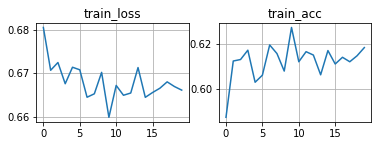

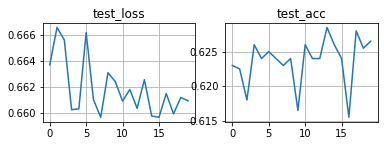

In [ ]:
print(history.history.keys())
plt.subplot(221)
plt.plot(history.history["loss"])
plt.grid()
plt.title("train_loss")

plt.subplot(222)
plt.plot(history.history["accuracy"])
plt.grid()
plt.title("train_acc")
plt.show()

plt.subplot(221)
plt.plot(history.history["val_loss"])
plt.grid()
plt.title("test_loss")

plt.subplot(222)
plt.plot(history.history["val_accuracy"])
plt.grid()
plt.title("test_acc")
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Daming Colab/Ranking_siamese network/Model/SqueezeNet_Model_1op.h5')

In [ ]:
model_ND.save('/content/drive/MyDrive/Daming Colab/Ranking_siamese network/Model/SqueezeNet_Model_tfpl.h5')

In [ ]:
siamese_model.save('/content/drive/MyDrive/Daming Colab/Ranking_siamese network/Model/***********.h5')